In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from continuum import ClassIncremental
from continuum.datasets import CIFAR100, CIFAR10
from continuum.tasks import split_train_val
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CIFAR100("my/data/path", download=True, train=True)

# Define the class-incremental scenario
scenario = ClassIncremental(
    dataset,
    increment=10,  # Add 2 new classes per task
    initial_increment=10  # Start with 2 classes
)

print(f"Number of classes: {scenario.nb_classes}.")
print(f"Number of tasks: {scenario.nb_tasks}.")

# Define the NN model
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_channel):
        super(CNN, self).__init__()
        self.conv_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_dim, num_channel, kernel_size=5),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.conv_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            # torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        self.pool1 = torch.nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv_layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.conv_layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(num_channel, num_channel, kernel_size=3),
            torch.nn.BatchNorm2d(num_channel),
            torch.nn.ReLU(),
        )
        self.backbone = nn.Sequential(
            self.conv_layer1,
            self.conv_layer2,
            self.pool1,
            self.conv_layer3,
            self.conv_layer4,
            nn.Flatten(start_dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(num_channel*9*9, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()
    accuracy = correct / len(labels)
    return accuracy.item()

# Function to calculate NTK (based on simrnn_ntk)
def simrnn_ntk(inputseqs, model):
    grads = []
    for seq in inputseqs:
        model.zero_grad()  # Clear previous gradients
        out = model(seq.unsqueeze(0).to(device))  # Add batch dimension and move to GPU
        # Ensure output is a scalar for backward()
        if out.dim() > 0:
            out = out.sum()
        out.backward()  # Compute gradients
        # Collect gradients for all parameters
        grad = torch.cat([p.grad.flatten() if p.grad is not None else torch.zeros_like(p).flatten()
                          for p in model.parameters()])
        grads.append(grad)
    
    batchsize = len(inputseqs)
    ntk = torch.zeros(batchsize, batchsize, device=device)
    for i in range(batchsize):
        for j in range(0, i+1):
            ntk[i, j] = ntk[j, i] = torch.dot(grads[i], grads[j])
    return ntk.cpu().numpy()  # Move NTK matrix back to CPU for plotting

# Function to evaluate the model on a dataset
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)  # Move data to GPU
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# Lists to store fixed samples and validation tasksets
fixed_train_samples = []
fixed_val_samples = []
val_tasksets = []
train_tasksets = []

# Function to extract fixed samples and validation tasksets
def extract_fixed_samples_and_tasksets(scenario):
    for task_id, train_taskset in enumerate(scenario):
        # Split the taskset into training and validation sets
        train_taskset, val_taskset = split_train_val(train_taskset, val_split=0.1)
        
        # Store fixed samples for NTK calculation
        fixed_train_samples.append([train_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        fixed_val_samples.append([val_taskset[i][0].to(device) for i in range(10)])  # Move to GPU
        
        # Store validation taskset
        val_tasksets.append(val_taskset)
        train_tasksets.append(train_taskset)

def create_replay_dataloader(tid,sample_num=500,batch_size=32):
    all_sample_data = []
    for id in range(tid):
        task_data = [d for d in train_tasksets[id]]
        task_data_sample = random.sample(task_data,sample_num)
        all_sample_data.extend(task_data_sample)
    return DataLoader(all_sample_data, batch_size=batch_size, shuffle=True)    

# Function to train, evaluate, and plot NTK metrics
def train_and_evaluate_with_buffer(model, epochs_per_task):
    num_tasks = len(val_tasksets)
    total_epochs = num_tasks * epochs_per_task

    # Initialize lists to store results
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    task_accuracies = [[] for _ in range(num_tasks)]  # Accuracy on all tasks after each epoch
    train_ntk_matrices = [[] for _ in range(num_tasks)]
    test_ntk_matrices = [[] for _ in range(num_tasks)]

    # Train and evaluate on each task
    for task_id in range(num_tasks):
        print(f"\n=== Task {task_id + 1} ===")
        
        train_loader = DataLoader(train_tasksets[task_id], batch_size=32, shuffle=True)
        val_loader = DataLoader(val_tasksets[task_id], batch_size=32, shuffle=False)
        
        # Train the model on the current task
        model.train()
        for epoch in range(epochs_per_task):
            global_epoch = task_id * epochs_per_task + epoch  # Global epoch index
            running_loss = 0.0
            running_accuracy = 0.0
            correct = 0
            total = 0
            batch_len = len(train_loader)
            for x, y, t in train_loader:
                x, y = x.to(device), y.to(device)  # Move data to GPU
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                correct += (pred == y).sum().item()
                total += y.size(0)
                
            # Experience replay
            if task_id > 0:
                buffer_loader = create_replay_dataloader(task_id)
                batch_len += len(buffer_loader)
                for x, y, t in buffer_loader:
                    x, y = x.to(device), y.to(device)  # Move data to GPU
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    _, pred = torch.max(outputs, 1)
                    correct += (pred == y).sum().item()
                    total += y.size(0)
                
            train_loss = running_loss / batch_len
            train_accuracy = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Evaluate on the validation set
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {global_epoch + 1}, "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Calculate NTK for fixed samples at the end of each epoch
            model.eval()
            for t in range(task_id + 1):
                train_ntk = simrnn_ntk(fixed_train_samples[t], model)
                test_ntk = simrnn_ntk(fixed_val_samples[t], model)
                train_ntk_matrices[t].append(train_ntk)
                test_ntk_matrices[t].append(test_ntk)

            # Evaluate the model on all tasks seen so far using fixed validation sets
            for t in range(task_id + 1):
                val_loader_t = DataLoader(val_tasksets[t], batch_size=32, shuffle=False)
                _, accuracy = evaluate(model, val_loader_t, criterion)
                task_accuracies[t].append(accuracy)
                print(f"Accuracy on Task {t + 1} at Epoch {global_epoch + 1}: {accuracy:.4f}")

    def calculate_ntk_metrics(ntk_matrices):
        norms = []
        max_eigenvalues = []
        min_eigenvalues = []
        for task_ntk_matrices in ntk_matrices:
            task_norms = []
            task_max_eigenvalues = []
            task_min_eigenvalues = []
            for ntk_matrix in task_ntk_matrices:
                task_norms.append(np.linalg.norm(ntk_matrix, ord='fro'))  # Use numpy.linalg.norm
                eigenvalues = np.linalg.eigvalsh(ntk_matrix)  # Use numpy.linalg.eigvalsh
                task_max_eigenvalues.append(eigenvalues[-1])
                task_min_eigenvalues.append(eigenvalues[0])
            norms.append(task_norms)
            max_eigenvalues.append(task_max_eigenvalues)
            min_eigenvalues.append(task_min_eigenvalues)
        return norms, max_eigenvalues, min_eigenvalues

    # Calculate NTK metrics for train and test NTK matrices
    train_ntk_norms, train_ntk_max_eigenvalues, train_ntk_min_eigenvalues = calculate_ntk_metrics(train_ntk_matrices)
    test_ntk_norms, test_ntk_max_eigenvalues, test_ntk_min_eigenvalues = calculate_ntk_metrics(test_ntk_matrices)

        
    def plot_ntk_metrics(ntk_metrics, title, ylabel):
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, len(ntk_metrics)))  # Assign a color to each task

        for t in range(len(ntk_metrics)):
            # Extract NTK metrics for Task t's dataset
            ntk_metrics_task = ntk_metrics[t]

            # The x-axis starts from the epoch when the task was introduced
            x_values = range(t * epochs_per_task, total_epochs)
            y_values = ntk_metrics_task

            # Plot the curve for Task t's dataset
            plt.plot(x_values, y_values, marker='o', label=f'Task {t} Dataset', color=colors[t])

        # Customize x-axis ticks and labels
        xticks = np.arange(0, total_epochs, epochs_per_task)  # Set ticks at the start of each task
        xticklabels = [f"Task {i}" for i in range(len(xticks))]  # Label ticks as Task 0, Task 1, etc.
        plt.xticks(xticks, xticklabels)  # Apply custom ticks and labels

        plt.xlabel('Task')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot NTK norms
    plot_ntk_metrics(train_ntk_norms, title='Train NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Norm')
    plot_ntk_metrics(test_ntk_norms, title='Test NTK Norms for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Norm')

    # Plot NTK max eigenvalues
    plot_ntk_metrics(train_ntk_max_eigenvalues, title='Train NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Max Eigenvalue')
    plot_ntk_metrics(test_ntk_max_eigenvalues, title='Test NTK Max Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Max Eigenvalue')

    # Plot NTK min eigenvalues
    plot_ntk_metrics(train_ntk_min_eigenvalues, title='Train NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Train NTK Min Eigenvalue')
    plot_ntk_metrics(test_ntk_min_eigenvalues, title='Test NTK Min Eigenvalues for Each Task\'s Dataset Across Epochs', ylabel='Test NTK Min Eigenvalue')

    # Plot task accuracies
    plot_ntk_metrics(task_accuracies, title='Test Accuracy for Each Task\'s Dataset Across Epochs', ylabel='Test Accuracy')

    return train_ntk_matrices, test_ntk_matrices, task_accuracies

# Example usage:
# First, extract fixed samples and tasksets
extract_fixed_samples_and_tasksets(scenario)



=== Task 1 ===
Epoch 1, Train Loss: 1.8705, Val Loss: 1.5612, Train Accuracy: 0.3633, Val Accuracy: 0.4800
Accuracy on Task 1 at Epoch 1: 0.4800
Epoch 2, Train Loss: 1.4411, Val Loss: 1.3848, Train Accuracy: 0.5127, Val Accuracy: 0.5180
Accuracy on Task 1 at Epoch 2: 0.5180
Epoch 3, Train Loss: 1.2252, Val Loss: 1.2896, Train Accuracy: 0.5944, Val Accuracy: 0.5620
Accuracy on Task 1 at Epoch 3: 0.5620
Epoch 4, Train Loss: 1.0295, Val Loss: 1.1630, Train Accuracy: 0.6553, Val Accuracy: 0.6200
Accuracy on Task 1 at Epoch 4: 0.6200
Epoch 5, Train Loss: 0.8439, Val Loss: 1.2030, Train Accuracy: 0.7047, Val Accuracy: 0.6240
Accuracy on Task 1 at Epoch 5: 0.6240
Epoch 6, Train Loss: 0.6315, Val Loss: 1.1975, Train Accuracy: 0.7876, Val Accuracy: 0.6460
Accuracy on Task 1 at Epoch 6: 0.6460
Epoch 7, Train Loss: 0.4712, Val Loss: 1.3529, Train Accuracy: 0.8378, Val Accuracy: 0.6240
Accuracy on Task 1 at Epoch 7: 0.6240
Epoch 8, Train Loss: 0.3333, Val Loss: 1.4961, Train Accuracy: 0.8833, Val

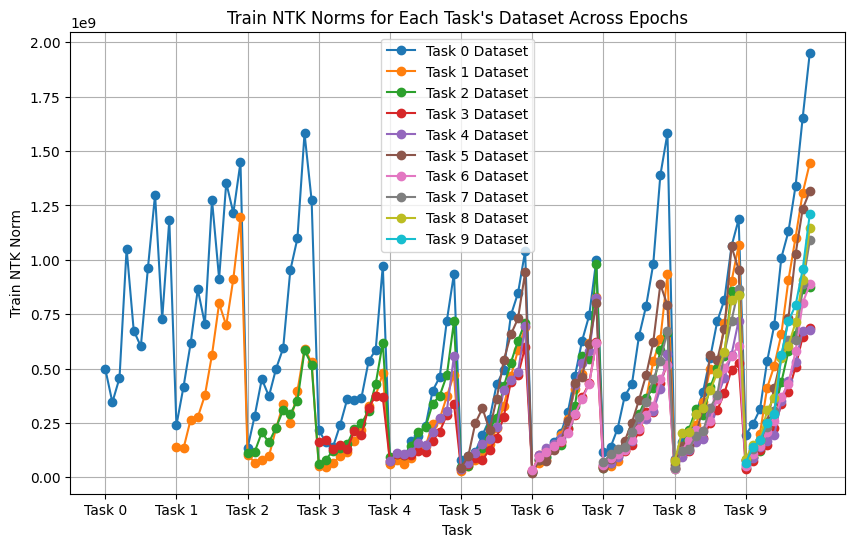

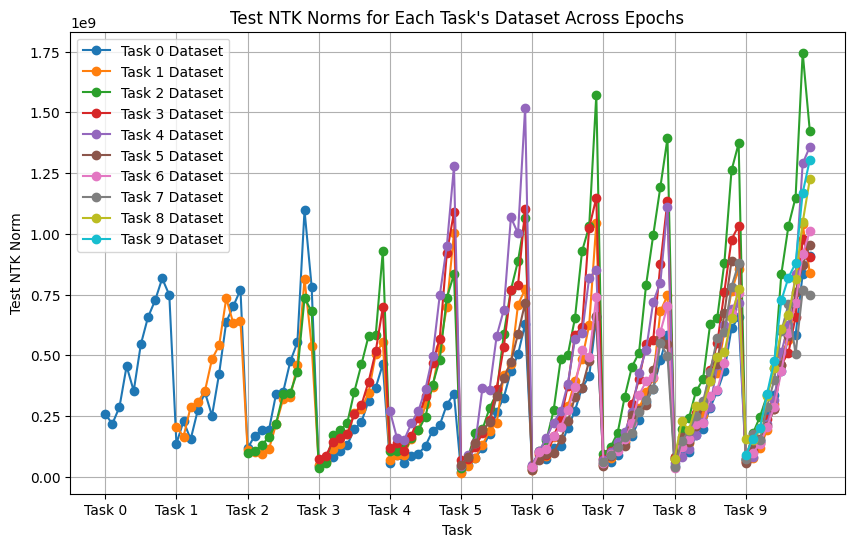

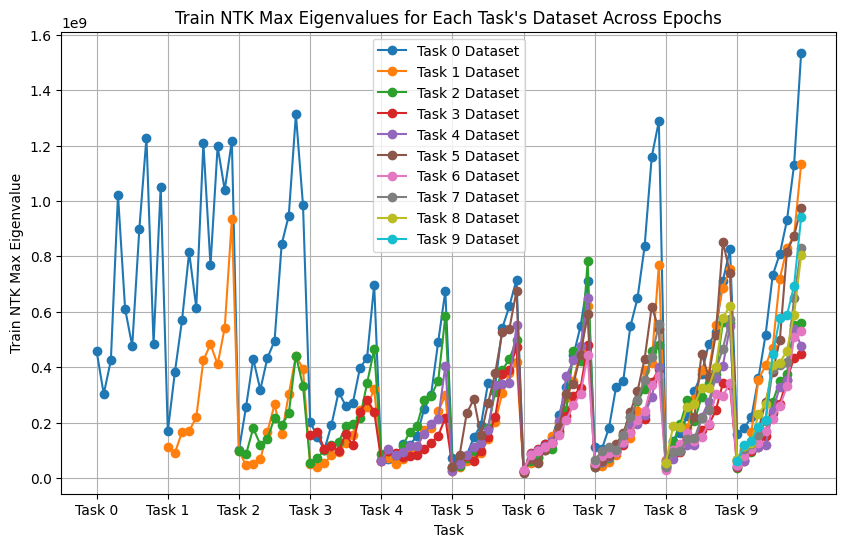

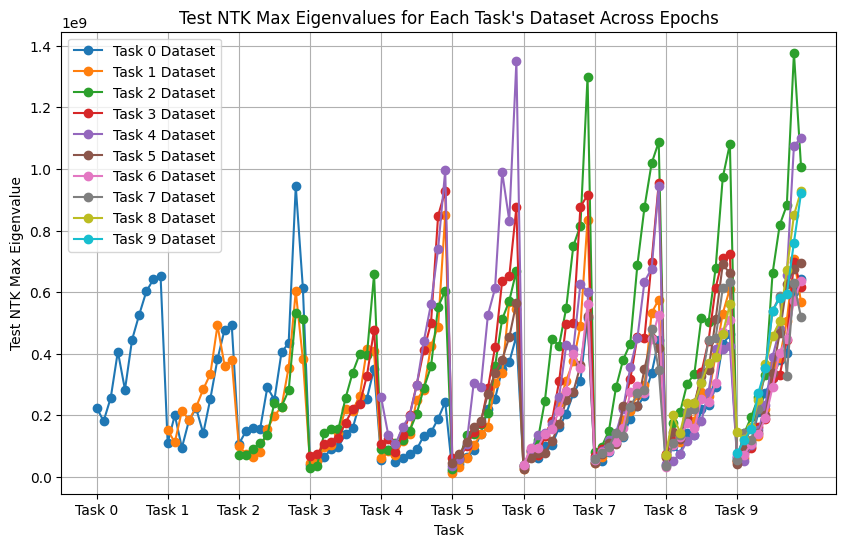

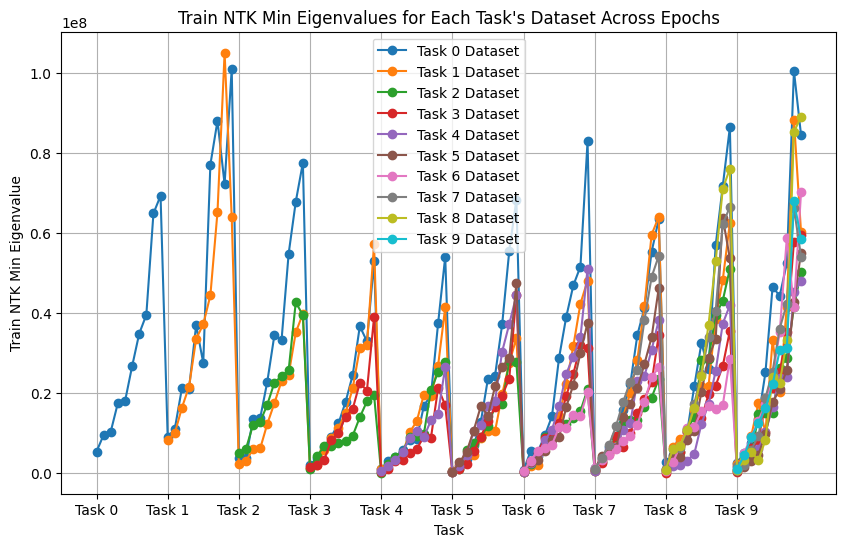

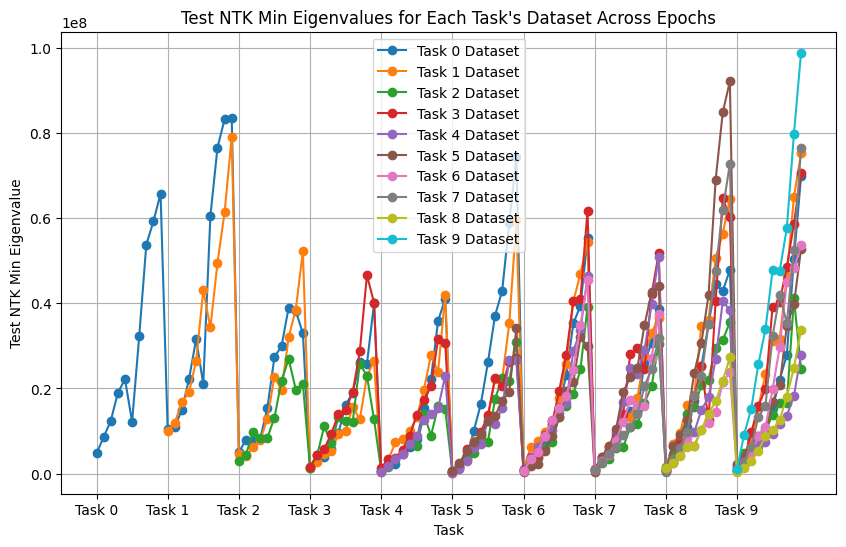

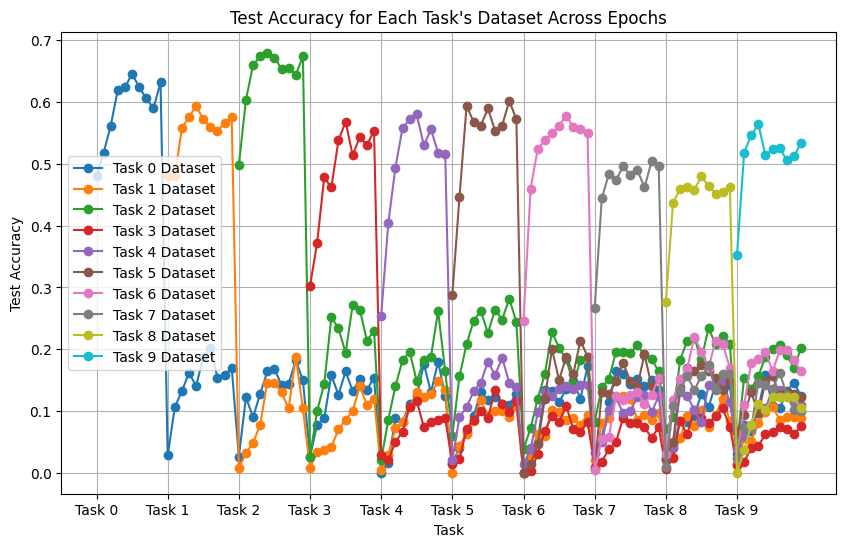


=== Task 1 ===
Epoch 1, Train Loss: 2.0676, Val Loss: 1.5313, Train Accuracy: 0.3462, Val Accuracy: 0.5080
Accuracy on Task 1 at Epoch 1: 0.5080
Epoch 2, Train Loss: 1.5509, Val Loss: 1.4380, Train Accuracy: 0.4744, Val Accuracy: 0.5020
Accuracy on Task 1 at Epoch 2: 0.5020
Epoch 3, Train Loss: 1.3285, Val Loss: 1.3839, Train Accuracy: 0.5491, Val Accuracy: 0.5780
Accuracy on Task 1 at Epoch 3: 0.5780
Epoch 4, Train Loss: 1.1211, Val Loss: 1.2246, Train Accuracy: 0.6240, Val Accuracy: 0.6120
Accuracy on Task 1 at Epoch 4: 0.6120
Epoch 5, Train Loss: 0.9653, Val Loss: 1.2508, Train Accuracy: 0.6751, Val Accuracy: 0.6160
Accuracy on Task 1 at Epoch 5: 0.6160
Epoch 6, Train Loss: 0.7665, Val Loss: 1.2048, Train Accuracy: 0.7358, Val Accuracy: 0.6220
Accuracy on Task 1 at Epoch 6: 0.6220
Epoch 7, Train Loss: 0.6348, Val Loss: 1.3562, Train Accuracy: 0.7824, Val Accuracy: 0.5920
Accuracy on Task 1 at Epoch 7: 0.5920
Epoch 8, Train Loss: 0.5041, Val Loss: 1.2821, Train Accuracy: 0.8298, Val

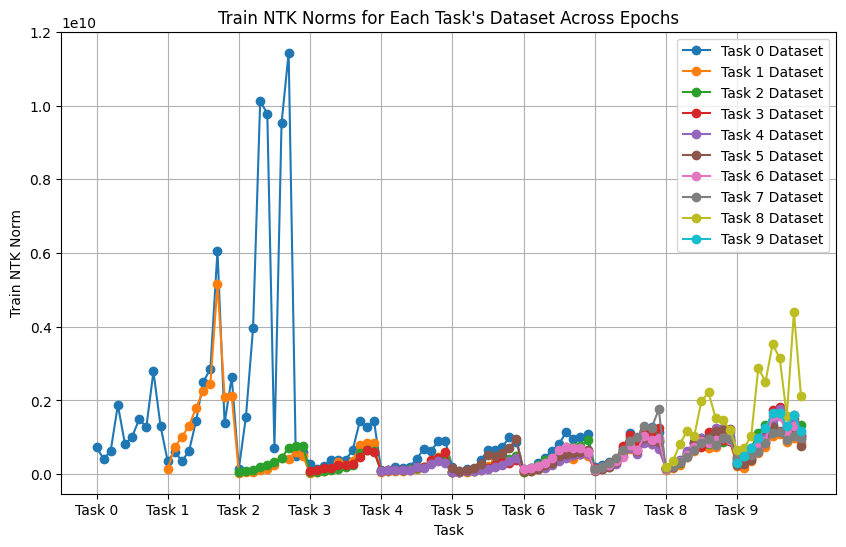

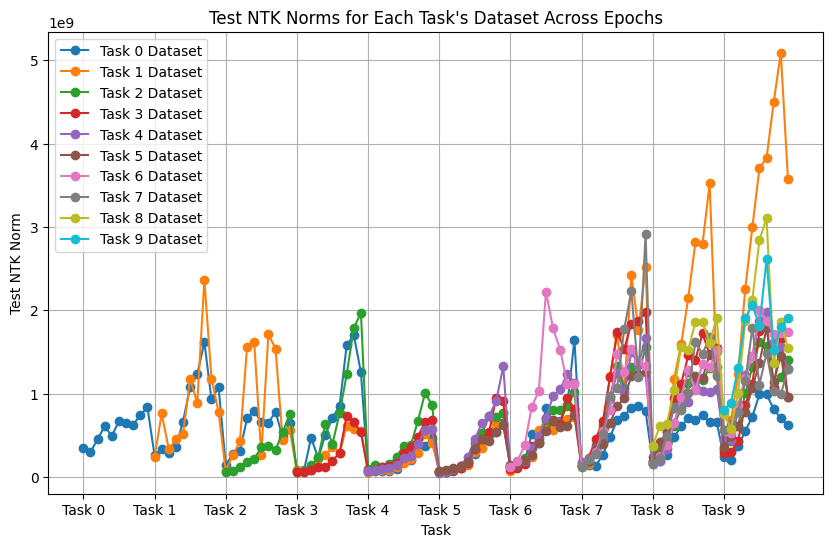

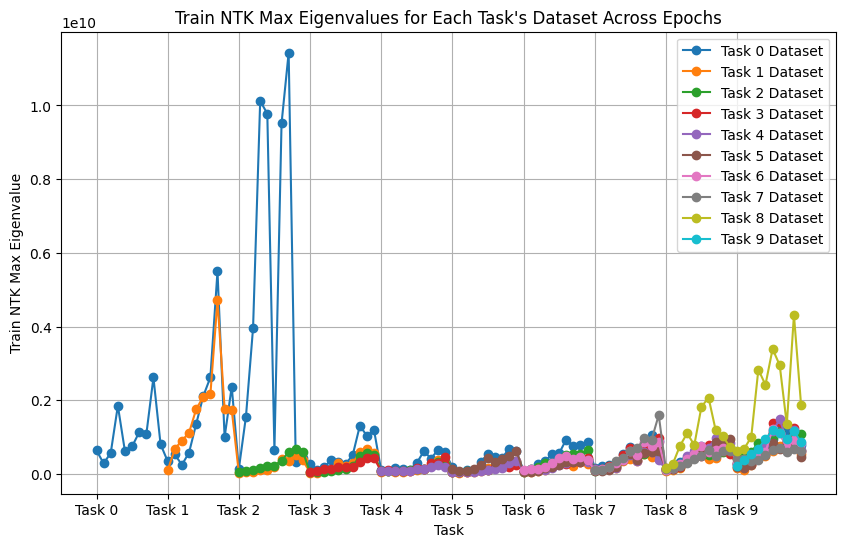

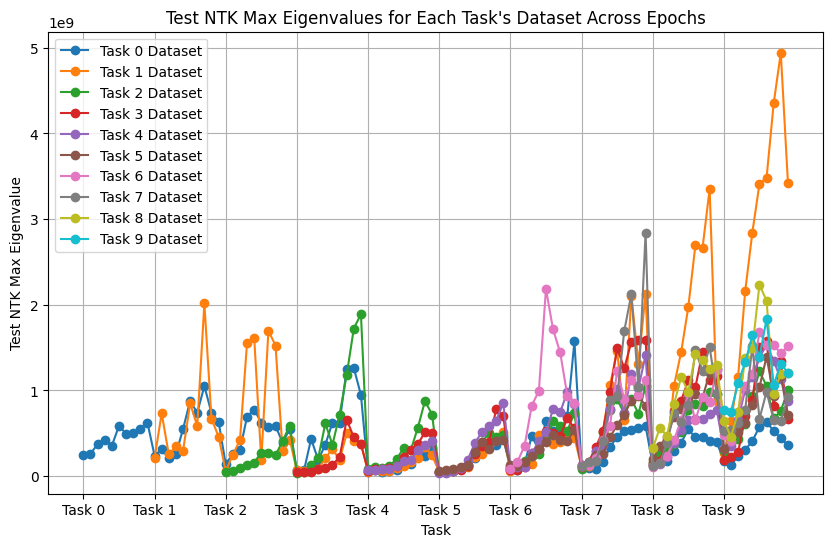

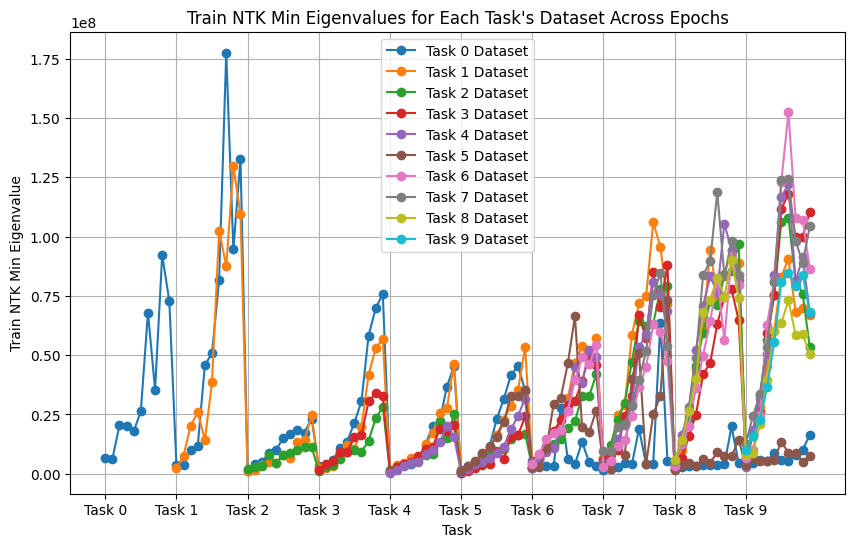

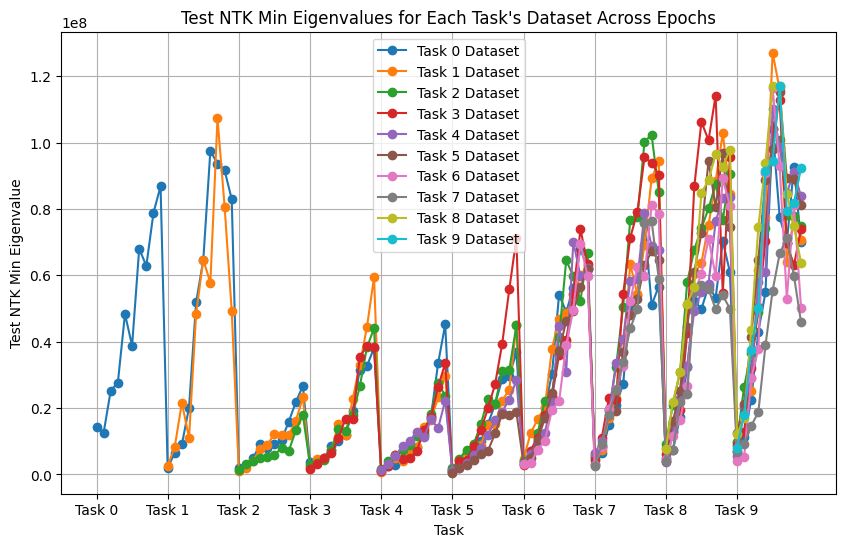

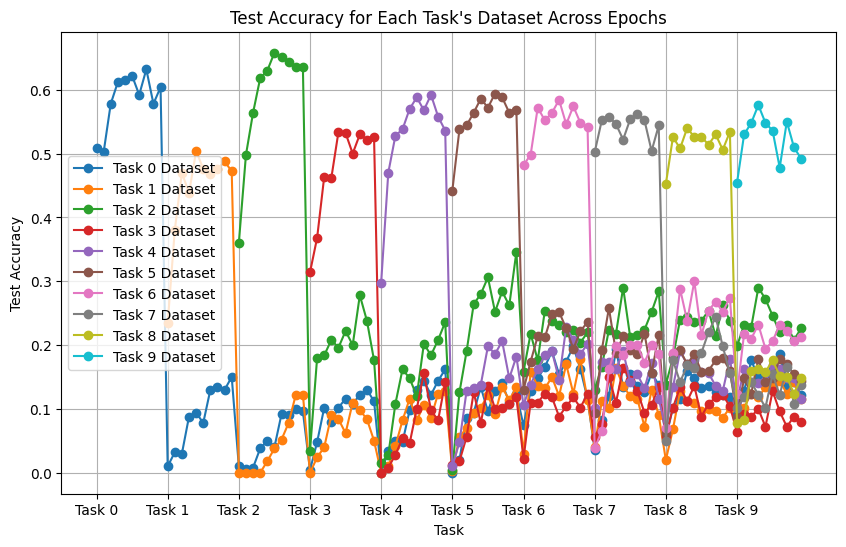

In [20]:
layer_sizes_list = [
    [3,1000,100,64],
    [3,5000,100,64],
]

metrics = {
    "CNN":{
        "CIFAR100": {
            "10-10-10": {
                "1000_64": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None},
                "5000_64": {"train_ntk_matrices": None, "test_ntk_matrices": None, "task_accuracies": None}
            }
        }
    }
}

for layer_sizes in layer_sizes_list:
    width = layer_sizes[1]  
    input_dim, hidden_dim, output_dim, channel = layer_sizes
    model = CNN(input_dim, hidden_dim, output_dim, channel ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs_per_task = 10

    train_ntk_matrices, test_ntk_matrices, task_accuracies = train_and_evaluate_with_buffer(model, epochs_per_task)

    metrics["CNN"]["CIFAR100"]["10-10-10"][str(width)] = {
        "train_ntk_matrices": train_ntk_matrices,
        "test_ntk_matrices": test_ntk_matrices,
        "task_accuracies": task_accuracies
    }
    
import pickle 
with open("cnn_cifar100_10_10_10epo_cuda.pkl", "wb") as file:
    pickle.dump(metrics, file)